# Analyzing NYC High School Data

This project is part of the guided projects on dataquest.io. Some of the initial code is provided by dataquest while the rest of the analysis is my work.

## Data Preparation
### Read in the Data

In [2]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\kamra\Miniconda3\envs\DSEnvConda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


### Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations

Let's dive further in our analysis and explore the correlation of `sat_score` with some of the `survey_fields` such as enrollment size and various student expectation scores
* `saf_s_10` - Safety and Respect score based on student responses
* `com_s_10` - Communication score based on student responses
* `eng_s_10` - Engagement score based on student responses
* `aca_s_10` - Academic expectations score based on student responses

First we will go ahead and make barplot of the correlations of all of the fields indicated in the survey. The list of fields is indicated in the beginning of this notebook.

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Add 'sat_score' column
survey_fields.append("sat_score")

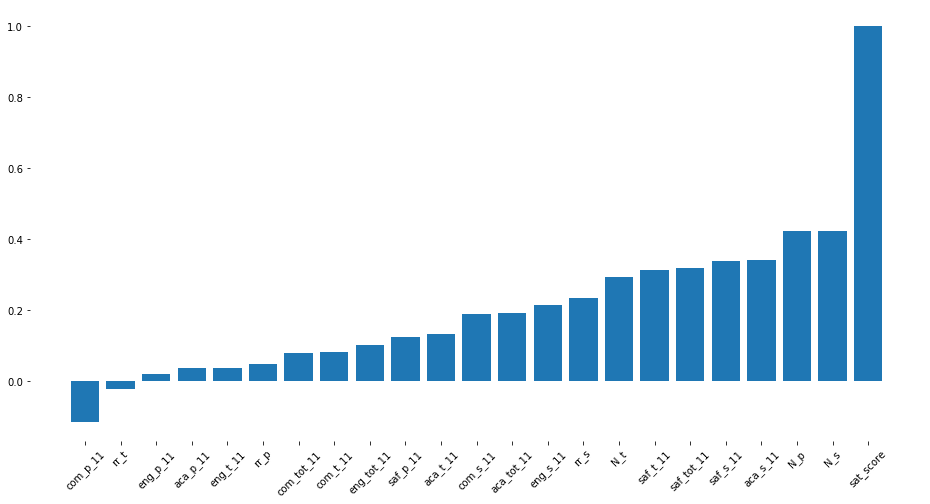

In [12]:
# calculate correlations
correlations = combined[survey_fields].corr()

# filter out only sat_score correlations
correlations = correlations["sat_score"].sort_values()

# bar plot
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(correlations.index, correlations)
ax.set_xticklabels(labels=correlations.index, rotation=45)
[ax.spines[a].set_visible(False) for a in ax.spines]
plt.show()

The plot above describes the correlation of survey fields with the "sat_scores". We can make the following observations:
* Number of parent (`N_p`) and student respondents (`N_s`) have a high correlation with the `sat_score`. Number of teaher respondents (`N_t`) also has a relatively high correlation with sat_score. One can say that schools with more engaging parents, students and teachers who participated in the survey and care about performance of the school have higher sat scores. 
* Students who have scored their schools high in terms of Academic Expectations (`aca_s_11`), Safety and Respect (`saf_s_11`) expected scores have higher sat_scores. It seems that schools which have high scores from students and teachers in terms of Safety and Respect tend to have higher sat scores.

## Exploring Safety and SAT Scores

Following our findings, we will dive deeper into the relationship discussed above more and try to figure out which schools have low safety scores. To do that we will make a scatter plot of `saf_s_11` column vs `sat_score`.

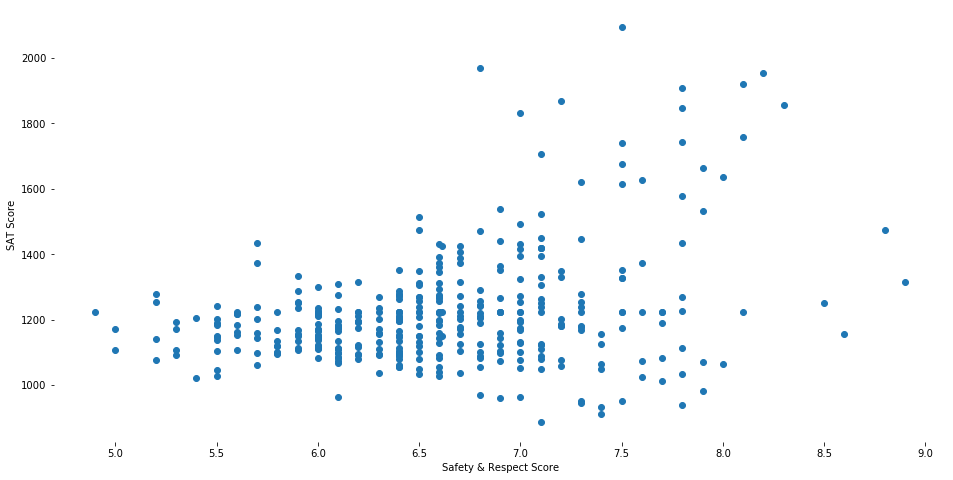

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(combined['saf_s_11'], combined['sat_score'])
[ax.spines[a].set_visible(False) for a in ax.spines]
ax.set_xlabel("Safety & Respect Score")
ax.set_ylabel("SAT Score")
plt.show()

We can observe that the relationship between the above two variables is not really linear. While there's correlation between the columns, there is no obvious linearity in the plot. Nevertheless, we can see that high sat scores are associated with high safety and respect scores, but this pattern is not consistent and is only valid for scores above 7.

**Next** let's map out the safety scores. We will:
* Compute the average safety score for each district 
* Make a map that shows safety scores by district

In [14]:
groupedby_district = combined.groupby("school_dist").agg("mean")

C:\Users\kamra\Miniconda3\envs\DSEnvConda\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kamra\Miniconda3\envs\DSEnvConda\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


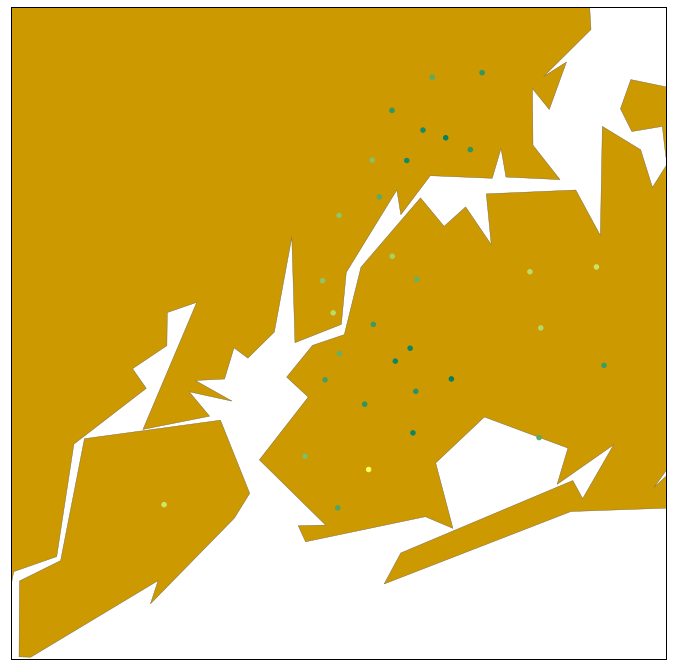

In [15]:
import os
os.environ["PROJ_LIB"] = "C:\\Users\\kamra\\Miniconda3\\envs\\DSEnvConda\\Library\\share"
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

plt.figure(figsize=(20,12))
m.drawmapboundary(fill_color='#ffffff')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='#CC9900',lake_color='aqua')
m.drawrivers(color='#6D5F47', linewidth=.4)

# calculate average by district
districts = combined.groupby("school_dist").agg("mean")

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=20, c=districts["sat_score"], zorder=2, latlon=True, cmap="summer")
plt.show()

From the map we can make the following observations.
* Schools in Upper Brooklyn and in Bronx have relatively higher sat scores
* Schools in Staten island, Central Queens and lower Brooklyn have relatively lower sat scores

## Exploring Race and SAT Scores

**Next** we will explore the race and sat scores.

There are few columns that indicate the percentage of each race at a given school.

* white_per
* asian_per
* black_per
* hispanic_per

By plotting out the correlations between these columns and `sat_score`, we can determine whether there are any racial differences in SAT performance.

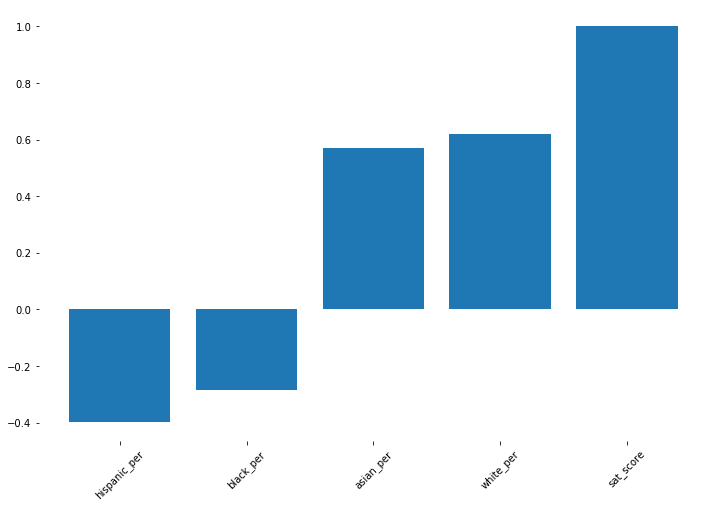

In [16]:
# calculate correlations
correlations = combined[["white_per", "asian_per", "black_per", "hispanic_per", "sat_score"]].corr()

# filter out only sat_score correlations
correlations = correlations["sat_score"].sort_values()

# bar plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(correlations.index, correlations)
ax.set_xticklabels(labels=correlations.index, rotation=45)
[ax.spines[a].set_visible(False) for a in ax.spines]
plt.show()

In the plot above we can clearly observe that
* Schools with high percentage of hispanic and black have lower sat scores
* Schools with high percentage of white and asian students have higher sat scores

Let's look at schools with high portion of hispanic students.

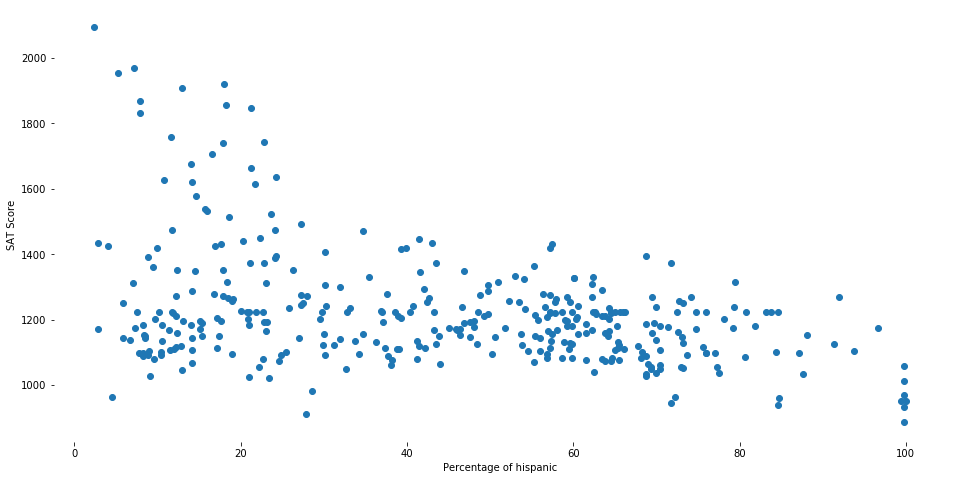

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(combined['hispanic_per'], combined['sat_score'])
[ax.spines[a].set_visible(False) for a in ax.spines]
ax.set_xlabel("Percentage of hispanic")
ax.set_ylabel("SAT Score")
plt.show()

The plot shows that schools with lower percent of hispanics is more likely to be associated with higher sat scores, whereas those with higher percentage of hispanics consistently with lower sat scores.

We can isolate schools that are almost fully hispanic. Let's isolate schools with more than 95% hispanic students.

In [18]:
combined.loc[combined["hispanic_per"] >= 95, "SCHOOL NAME"].tolist()

['MANHATTAN BRIDGES HIGH SCHOOL',
 'WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL',
 'GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS',
 'ACADEMY FOR LANGUAGE AND TECHNOLOGY',
 'INTERNATIONAL SCHOOL FOR LIBERAL ARTS',
 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE',
 'MULTICULTURAL HIGH SCHOOL',
 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL']

There are only 8 schools in the dataset with more than 95% hispanics. A quick search on the internet about these schools shows that:
* Some of these schools are specifically set up to serve hispanic minorities
* Quite a few of these schools are located in Manhattan
* Quite a few of the schools are set up with the goal of providing education opportunities for immigrants
* Some schools are specifically focused on teaching immigrant kids to speak English

Furthermore, let's investigate schools with less than 10% hispanic students and high sat scores (more than 1800).

In [19]:
filter_mask = (combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)
combined.loc[filter_mask, "SCHOOL NAME"].tolist()

['STUYVESANT HIGH SCHOOL',
 'BRONX HIGH SCHOOL OF SCIENCE',
 'BROOKLYN TECHNICAL HIGH SCHOOL',
 'QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE',
 'STATEN ISLAND TECHNICAL HIGH SCHOOL']

There are only 5 schools that fit this criteria. A quick search on the web shows that:
* These schools are usually specialized in specific education category (science, math, technology)
* These schools are top elite high schools

## Exploring Gender and SAT Scores

Next, let's dive into analyzing gender and its relationship with SAT Scores.

The columns that indicate the percentage of each gender at a school are:
* `male_per`
* `female_per`

Let's plot the bar plot of correlations between these columns and `sat_score`:

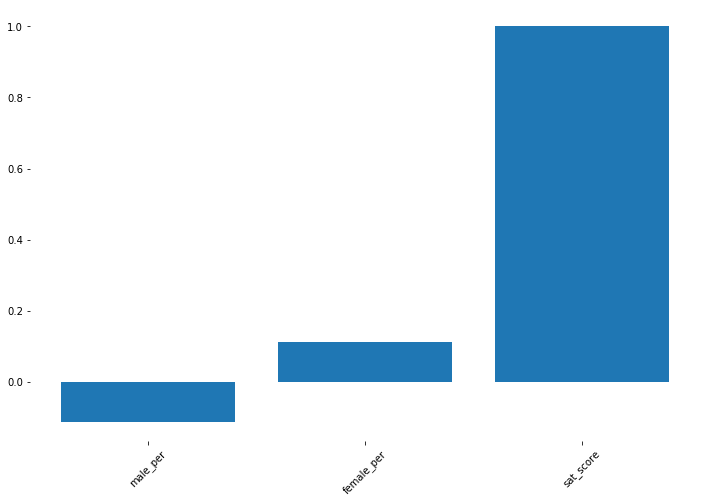

In [20]:
# calculate correlations
correlations = combined[["male_per", "female_per", "sat_score"]].corr()

# filter out only sat_score correlations
correlations = correlations["sat_score"].sort_values()

# bar plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(correlations.index, correlations)
ax.set_xticklabels(labels=correlations.index, rotation=45)
[ax.spines[a].set_visible(False) for a in ax.spines]
plt.show()

It seems that the schools with more females tend to have slightly higher sat score while the situation is opposite for males. Though the correlation coefficients are not as large, it's worth to investigate further.

Let's plot the scatter plot for `female_per` and `sat_score`

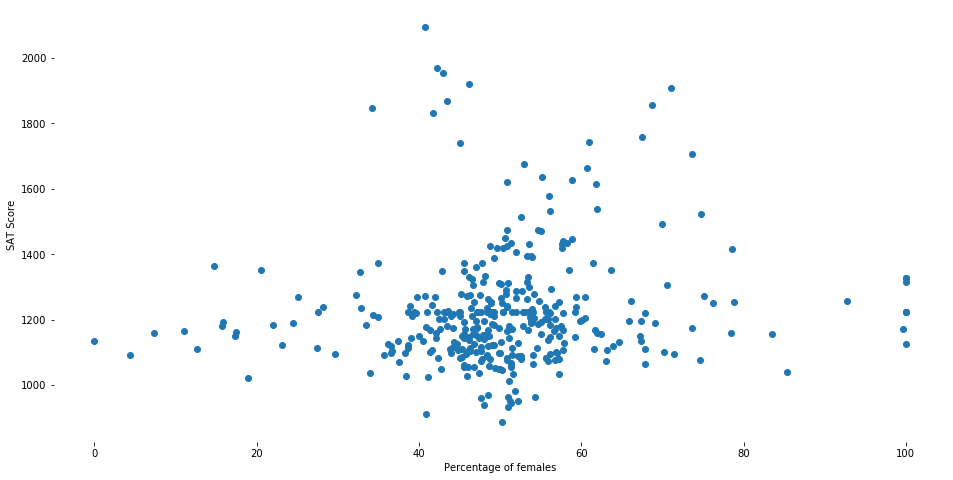

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(combined['female_per'], combined['sat_score'])
[ax.spines[a].set_visible(False) for a in ax.spines]
ax.set_xlabel("Percentage of females")
ax.set_ylabel("SAT Score")
plt.show()

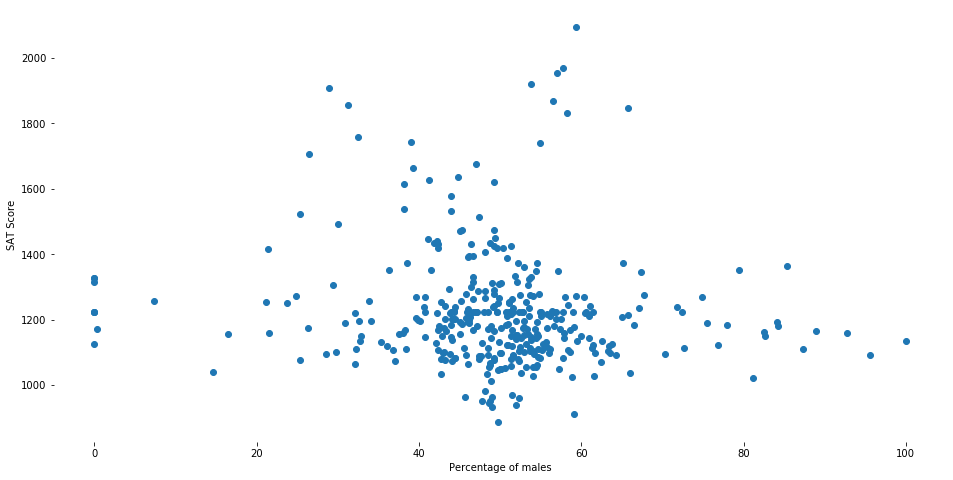

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(combined['male_per'], combined['sat_score'])
[ax.spines[a].set_visible(False) for a in ax.spines]
ax.set_xlabel("Percentage of males")
ax.set_ylabel("SAT Score")
plt.show()

It's quite difficult to say if there's a clear relationship between the female percentage and the sat scores, since both of the plots are quite similar. We can see that most of the schools have percentage of males and females within 40-60 percent range with sat_scores being in the range of 1000-1400. Here and there you have some schools that have high percent of males or females associated with sat_scores but there's not discernible pattern.

We can check the schools which have more females and also higher sat scores and look at them.

In [23]:
female_sat = (combined["female_per"] > 60) & (combined["sat_score"] > 1700)
combined.loc[female_sat, "SCHOOL NAME"].tolist()

['BARD HIGH SCHOOL EARLY COLLEGE',
 'ELEANOR ROOSEVELT HIGH SCHOOL',
 'BEACON HIGH SCHOOL',
 'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS',
 'TOWNSEND HARRIS HIGH SCHOOL']

After a quick lookup of these schools online we can see that
* These schools seem to either be specialized schools (science, math, visual arts) or
* Schools that are college-preparatory high schools
* Some of the schools (e.g TOWNSEND HARRIS HIGH SCHOOL) are ranked in the top 100

## Exploring AP Scores vs SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

To accomplish this, we will calculate the percentage of students in each school that took an AP exam. For that we need to divie the number of `AP Test Takers` by `total_enrollment`.

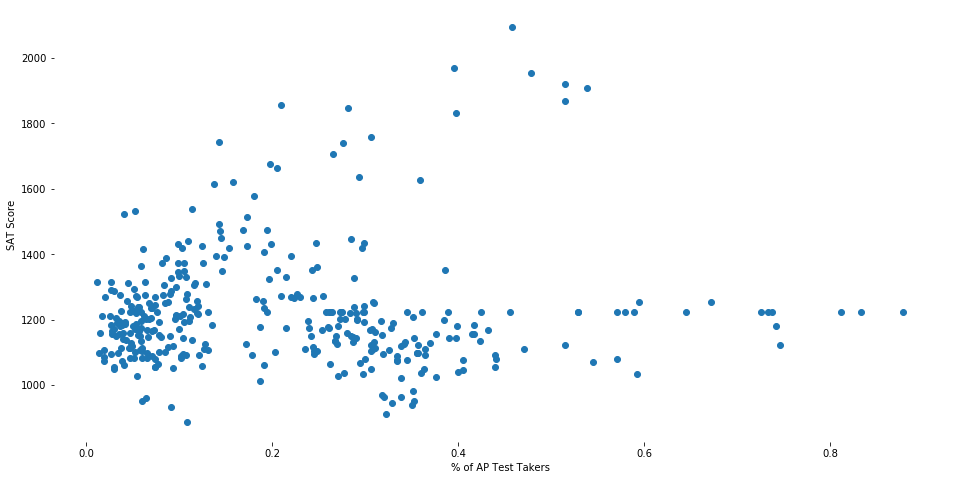

In [24]:
# calculate proportion of AP test takers
ap_per = combined["AP Test Takers "] / combined["total_enrollment"]

# scatter plot of relationship with sat scores
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(ap_per, combined['sat_score'])
[ax.spines[a].set_visible(False) for a in ax.spines]
ax.set_xlabel("% of AP Test Takers")
ax.set_ylabel("SAT Score")
plt.show()

The scatter plot shows us that while schools with up 20% of AP Test takers tend to have increasing SAT Scores, there are many schools with high percent of AP test takers but low SAT Scores. It would difficult to claim that there is a discernible positive correlation.

Next, we can continue with the investigation and try to tackle the following questions:
* Determing wheter there's a correlation between class size and SAT scores
* Figuring out which neighborhoods have the best schools
    If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
* Investigating the differences between parent, teacher, and student responses to surveys.
* Assigning scores to schools based on sat_score and other attributes.